In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# denoise images as a preprocessing step
def denoise_image(image):
    return cv2.GaussianBlur(image, (5, 5), 0)

# Define an ImageDataGenerator for data augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=denoise_image,
    validation_split=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Set the path to the dataset and parameters for loading the images
dataset_path = '/content/drive/My Drive/Rubber_Crepe'
image_size = (224, 224)  # Size of the input images
batch_size = 32  # Batch size for training

# Load images and labels from subdirectories for training and validation
train_generator = datagen.flow_from_directory(
    directory=dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',# Multi class classification
    subset='training')  # Training subset

validation_generator = datagen.flow_from_directory(
    directory=dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')   #Validation subset

test_generator = datagen.flow_from_directory(
    directory=dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False #test data to maintain consistency in evaluation
)

print(test_generator.class_indices)



Mounted at /content/drive
Found 603 images belonging to 5 classes.
Found 149 images belonging to 5 classes.
Found 752 images belonging to 5 classes.
{'Grade_1': 0, 'Grade_1x': 1, 'Grade_2': 2, 'Grade_3': 3, 'Grade_4': 4}


In [1]:
# Import necessary layers and models from keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Defining a Sequential model with convolutional, max pooling, flatten, dense, and dropout layers
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(5, activation='softmax', kernel_regularizer=l2(0.01))
])

# Compile the model with Adam optimizer and categorical_crossentropy loss function
model.compile(optimizer=Adam(learning_rate=0.0001),
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

# Display the model's architecture
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 512)               9

In [ ]:
from sklearn.utils import class_weight
import numpy as np

# Calculate class weights which are inversely proportional to class frequencies
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes)

class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)


{0: 1.005, 1: 0.9496062992125984, 2: 0.9885245901639345, 3: 1.0307692307692307, 4: 1.0307692307692307}


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Set up the early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)


# Train the model with the training and validation data generators
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=70 ,
    callbacks=[early_stopping],
    class_weight=class_weight_dict
)

Epoch 1/70
18/18 [==============================] - 694s 38s/step - loss: 9.7889 - accuracy: 0.2242 - val_loss: 7.1831 - val_accuracy: 0.3906
Epoch 2/70
18/18 [==============================] - 180s 10s/step - loss: 5.9193 - accuracy: 0.2847 - val_loss: 4.7578 - val_accuracy: 0.1719
Epoch 3/70
18/18 [==============================] - 162s 9s/step - loss: 4.1585 - accuracy: 0.3363 - val_loss: 3.6612 - val_accuracy: 0.3359
Epoch 4/70
18/18 [==============================] - 164s 9s/step - loss: 3.3498 - accuracy: 0.4133 - val_loss: 3.0869 - val_accuracy: 0.3438
Epoch 5/70
18/18 [==============================] - 165s 9s/step - loss: 2.9434 - accuracy: 0.3906 - val_loss: 2.8270 - val_accuracy: 0.5781
Epoch 6/70
18/18 [==============================] - 162s 9s/step - loss: 2.6384 - accuracy: 0.4133 - val_loss: 2.5336 - val_accuracy: 0.4375
Epoch 7/70
18/18 [==============================] - 160s 9s/step - loss: 2.4017 - accuracy: 0.4956 - val_loss: 2.3531 - val_accuracy: 0.4219
Epoch 8/70


In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

24/24 [==============================] - 139s 6s/step - loss: 1.0008 - accuracy: 0.7593
Test Loss: 1.0007967948913574
Test Accuracy: 0.7593085169792175


In [ ]:
from sklearn.metrics import classification_report
import numpy as np
# Get the predictions for the test data
predictions = model.predict(test_generator)

# Get the predicted class indices
predicted_classes = np.argmax(predictions, axis=1)

# Get the actual class indices
actual_classes = test_generator.classes

# Get the class labels from the generator
class_labels = list(test_generator.class_indices.keys())

# Generate the classification report
print(classification_report(actual_classes, predicted_classes, target_names=class_labels))

24/24 [==============================] - 108s 4s/step
              precision    recall  f1-score   support

     Grade_1       0.80      0.83      0.81       150
    Grade_1x       0.70      0.90      0.79       158
     Grade_2       0.64      0.67      0.66       152
     Grade_3       0.82      0.50      0.62       146
     Grade_4       0.97      0.97      0.97       146

    accuracy                           0.77       752
   macro avg       0.79      0.77      0.77       752
weighted avg       0.78      0.77      0.77       752



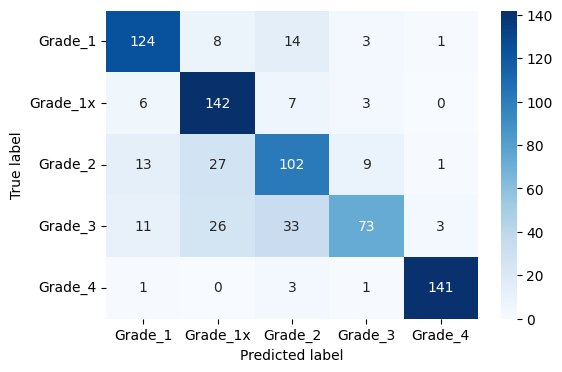

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the true class indices
true_classes = test_generator.classes

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix as a heatmap
fig, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, ax=ax)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

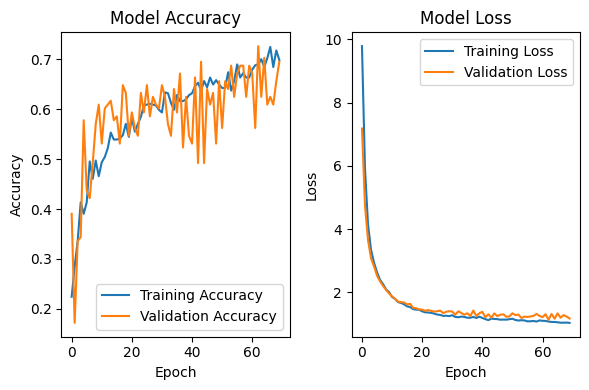

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 4))

# Plot the training and validation accuracy
axs[0].plot(history.history['accuracy'], label='Training Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title('Model Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend(loc='lower right')

# Plot the training and validation loss
axs[1].plot(history.history['loss'], label='Training Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_title('Model Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Path to a new image you want to test
new_image_path = '/content/drive/My Drive/323.JPG'
img = image.load_img(new_image_path, target_size=image_size)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255  # Rescale like during training

# Make a prediction
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction, axis=1)

# Output the predicted class
print(f"Predicted class: {predicted_class}")


1/1 [==============================] - 0s 118ms/step
Predicted class: [3]
